In [6]:
import os
import shutil
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


In [7]:
ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

GITHUB_REPO = "https://github.com/fruits-360/fruits-360-100x100"
CLONE_DIR = "dataset/fruits-360-100x100"

def download_dataset():
    os.makedirs("dataset", exist_ok=True)
    subprocess.run(["git", "clone", GITHUB_REPO, CLONE_DIR], check=True)
    
    os.makedirs(ROOT_DIR, exist_ok=True)
    shutil.move(os.path.join(CLONE_DIR, "Training"), TRAIN_DIR)
    shutil.move(os.path.join(CLONE_DIR, "Test"), TEST_DIR)
    shutil.rmtree(CLONE_DIR, ignore_errors=True)

if not os.path.exists(ROOT_DIR):
    download_dataset()

assert os.path.exists(TRAIN_DIR), f"{TRAIN_DIR} not found"
assert os.path.exists(TEST_DIR), f"{TEST_DIR} not found"
print(f"Dataset ready: {ROOT_DIR}")


Dataset ready: dataset/fruit360


In [8]:
class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []
        
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            label = class_name if self.variety else class_name.split()[0]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".png")):
                    self.samples.append((os.path.join(class_dir, img_name), label))
        
        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for i, lbl in self.label_to_idx.items()}
        
        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label_str


In [9]:
SIZE_VIS = 100

transform_vis = T.Compose([
    T.Resize((SIZE_VIS, SIZE_VIS)),
    T.ToTensor(),
])

test_dataset = Fruit360FolderDataset(TEST_DIR, transform=transform_vis, variety=False)

print(f"Test dataset: {len(test_dataset)} images, {len(test_dataset.label_to_idx)} classes")

classes_to_show = [
    "Apple", "Banana", "Tomato", "Zucchini", "Nut", "Orange", "Pepper", "Strawberry"
]

examples = []
seen_labels = set()

for img, label in test_dataset:
    if label in classes_to_show and label not in seen_labels:
        examples.append((img, label))
        seen_labels.add(label)
    if len(seen_labels) == len(classes_to_show):
        break

print(f"Selected {len(examples)} example images:")
print([lbl for _, lbl in examples])


Test: 43442 images, 79 classes
Test dataset: 43442 images, 79 classes
Selected 8 example images:
['Apple', 'Banana', 'Nut', 'Orange', 'Pepper', 'Strawberry', 'Tomato', 'Zucchini']


In [ ]:
import math

def clamp01(x):
    return torch.clamp(x, 0.0, 1.0)

degradations_camera = {
    # Baseline
    "clean": lambda x: x,
    
    # Grayscale
    "grayscale": lambda x: x.mean(dim=0, keepdim=True).repeat(3, 1, 1),
    
    # Blur (defocus / motion)
    "blur_mild": T.GaussianBlur(kernel_size=3, sigma=0.5),
    "blur_medium": T.GaussianBlur(kernel_size=5, sigma=1.0),
    "blur_strong": T.GaussianBlur(kernel_size=7, sigma=2.0),
    
    # Gaussian noise
    "noise_mild": lambda x: clamp01(x + torch.randn_like(x) * 0.03),
    "noise_medium": lambda x: clamp01(x + torch.randn_like(x) * 0.07),
    "noise_strong": lambda x: clamp01(x + torch.randn_like(x) * 0.15),
    
    # Lighting
    "dark": lambda x: clamp01(x * 0.4),
    "overexposed": lambda x: clamp01(x * 1.8),
    
    # Combined (noise + blur)
    "noisy_blurred": lambda x: T.GaussianBlur(kernel_size=5, sigma=1.0)(
        clamp01(x + torch.randn_like(x) * 0.10)
    ),
}

print("Camera degradations:")
for k in degradations_camera.keys():
    print(" -", k)


Camera degradations:
 - clean
 - grayscale
 - blur_mild
 - blur_medium
 - blur_strong
 - noise_mild
 - noise_medium
 - noise_strong
 - dark
 - overexposed
 - noisy_blurred


In [ ]:
def add_color_patches(x, num_patches, color, alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)):
    _, H, W = x.shape
    out = x.clone()
    
    for _ in range(num_patches):
        s = np.random.uniform(size_range[0], size_range[1])
        patch_area = s * H * W
        r = np.random.uniform(0.5, 1.5)
        patch_h = int(math.sqrt(patch_area * r))
        patch_w = int(math.sqrt(patch_area / r))
        patch_h = max(1, min(H, patch_h))
        patch_w = max(1, min(W, patch_w))
        
        top = np.random.randint(0, H - patch_h + 1)
        left = np.random.randint(0, W - patch_w + 1)
        bottom = top + patch_h
        right = left + patch_w
        
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        
        patch = out[:, top:bottom, left:right]
        blended = alpha * patch + (1 - alpha) * color
        out[:, top:bottom, left:right] = blended
    
    return clamp01(out)

def add_occlusion_patch(x, area_ratio=0.1, color=torch.tensor([0.5, 0.5, 0.5]).view(3,1,1), alpha=0.5):
    _, H, W = x.shape
    out = x.clone()
    
    patch_area = area_ratio * H * W
    r = np.random.uniform(0.5, 1.5)
    patch_h = int(math.sqrt(patch_area * r))
    patch_w = int(math.sqrt(patch_area / r))
    patch_h = max(1, min(H, patch_h))
    patch_w = max(1, min(W, patch_w))
    
    top = np.random.randint(0, H - patch_h + 1)
    left = np.random.randint(0, W - patch_w + 1)
    bottom = top + patch_h
    right = left + patch_w
    
    patch = out[:, top:bottom, left:right]
    blended = alpha * patch + (1 - alpha) * color
    out[:, top:bottom, left:right] = blended
    
    return clamp01(out)

# Colors
color_dirt = torch.tensor([0.3, 0.25, 0.2]).view(3,1,1) 
color_bruise = torch.tensor([0.25, 0.2, 0.15]).view(3,1,1)

degradations_fruit = {
    "dirty_mild": lambda x: add_color_patches(x, num_patches=2, color=color_dirt,
                                              alpha_range=(0.5, 0.8), size_range=(0.03, 0.08)),
    "dirty_strong": lambda x: add_color_patches(x, num_patches=4, color=color_dirt,
                                                alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)),
    "bruised_mild": lambda x: add_color_patches(x, num_patches=1, color=color_bruise,
                                                alpha_range=(0.4, 0.7), size_range=(0.03, 0.08)),
    "bruised_strong": lambda x: add_color_patches(x, num_patches=3, color=color_bruise,
                                                  alpha_range=(0.3, 0.6), size_range=(0.05, 0.15)),
    "occlusion_small": lambda x: add_occlusion_patch(x, area_ratio=0.10, alpha=0.5),
    "occlusion_medium": lambda x: add_occlusion_patch(x, area_ratio=0.20, alpha=0.5),
}

print("Fruit degradations:")
for k in degradations_fruit.keys():
    print(" -", k)


Fruit degradations:
 - dirty_mild
 - dirty_strong
 - bruised_mild
 - bruised_strong
 - occlusion_small
 - occlusion_medium


In [ ]:
def show_degradations_for_image(img_tensor, label, degradations_dict, title_prefix="", n_cols=5, figsize=(15, 6)):
    """
    img_tensor: 3×H×W in [0,1]
    degradations_dict: nome -> funzione(x)
    """
    names = list(degradations_dict.keys())
    n = len(names)
    n_rows = int(np.ceil(n / n_cols))
    
    plt.figure(figsize=figsize)
    for i, name in enumerate(names):
        ax = plt.subplot(n_rows, n_cols, i+1)
        with torch.no_grad():
            x_deg = degradations_dict[name](img_tensor)
        x_deg = clamp01(x_deg)
        img_np = x_deg.permute(1, 2, 0).cpu().numpy()
        ax.imshow(img_np)
        ax.set_title(name, fontsize=8)
        ax.axis("off")
    
    plt.suptitle(f"{title_prefix} – {label}", fontsize=12)
    plt.tight_layout()
    plt.show()


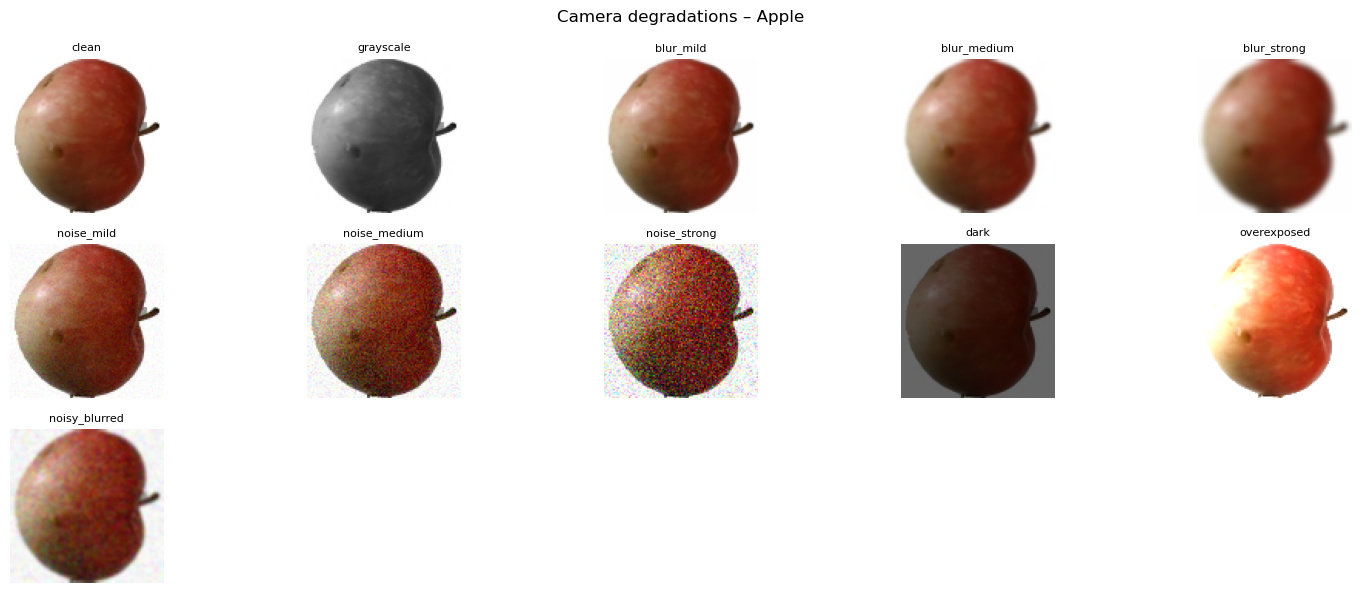

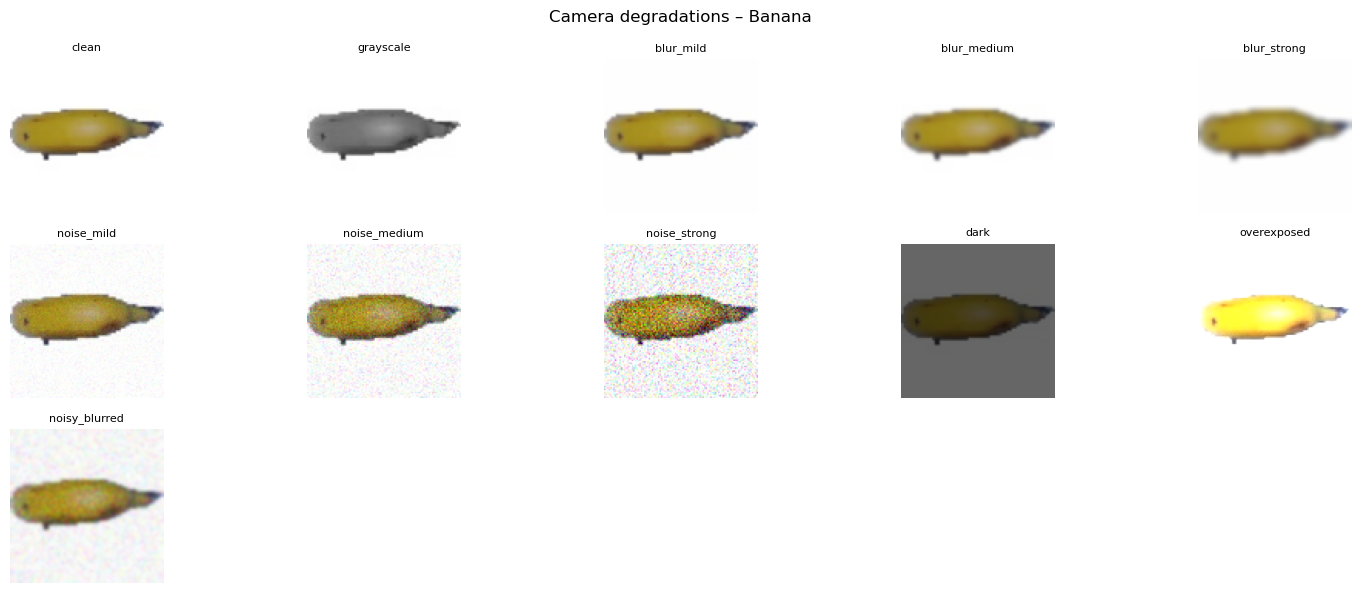

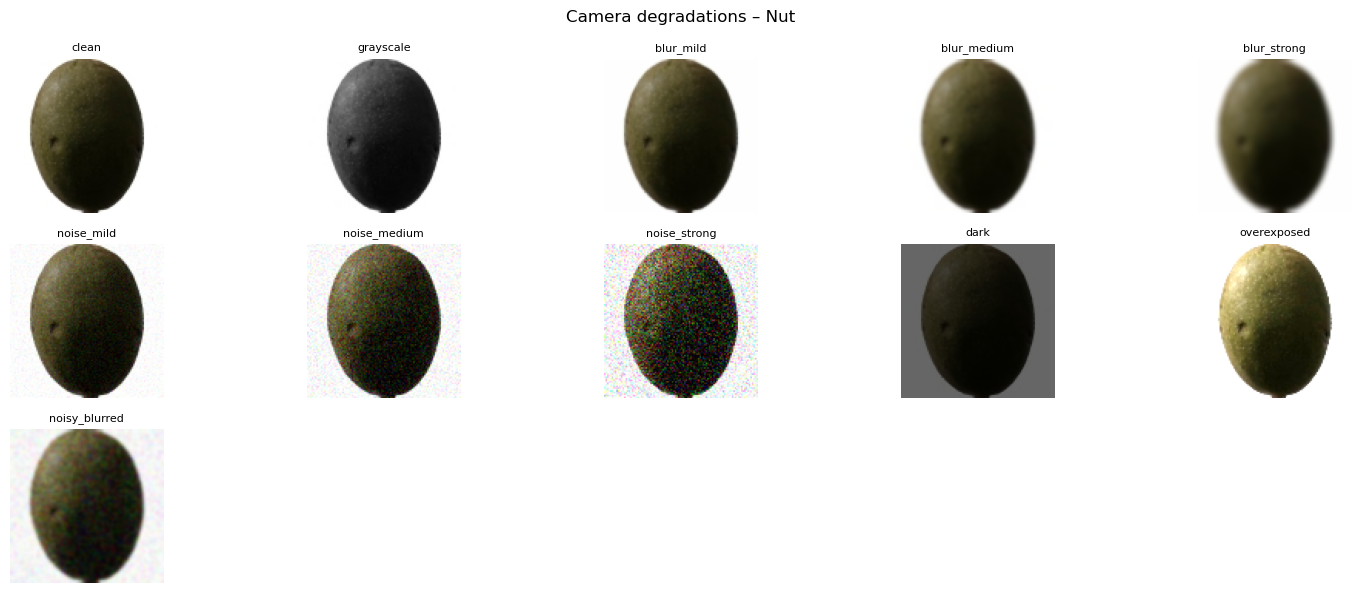

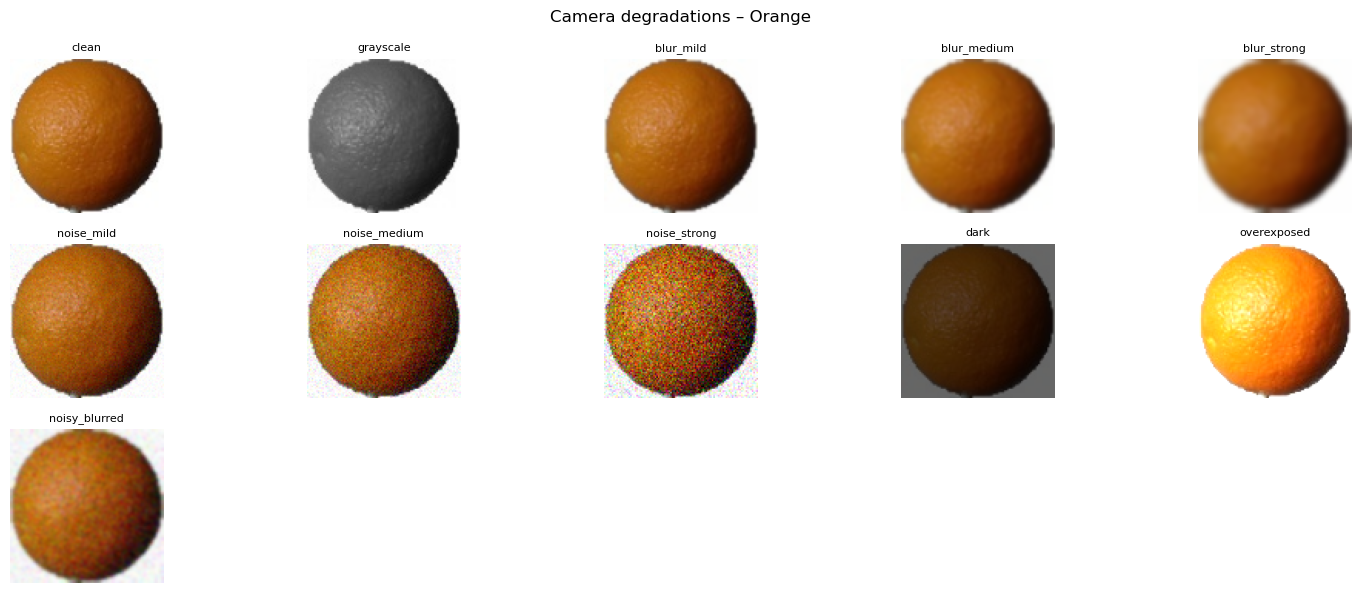

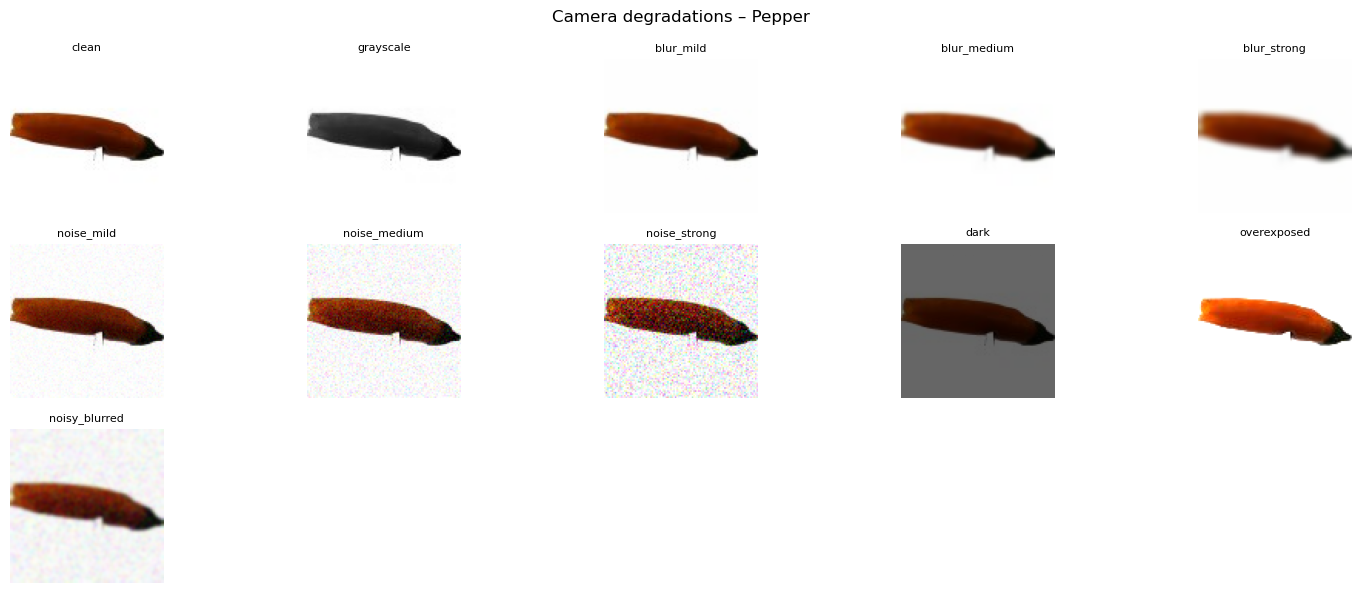

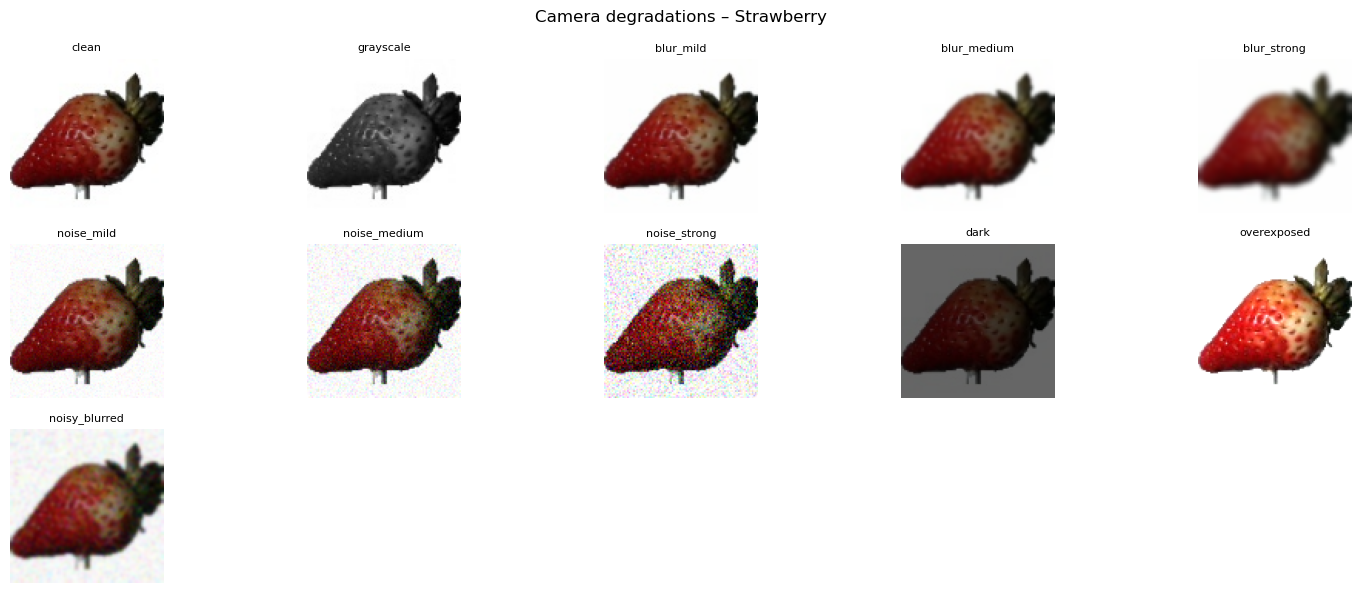

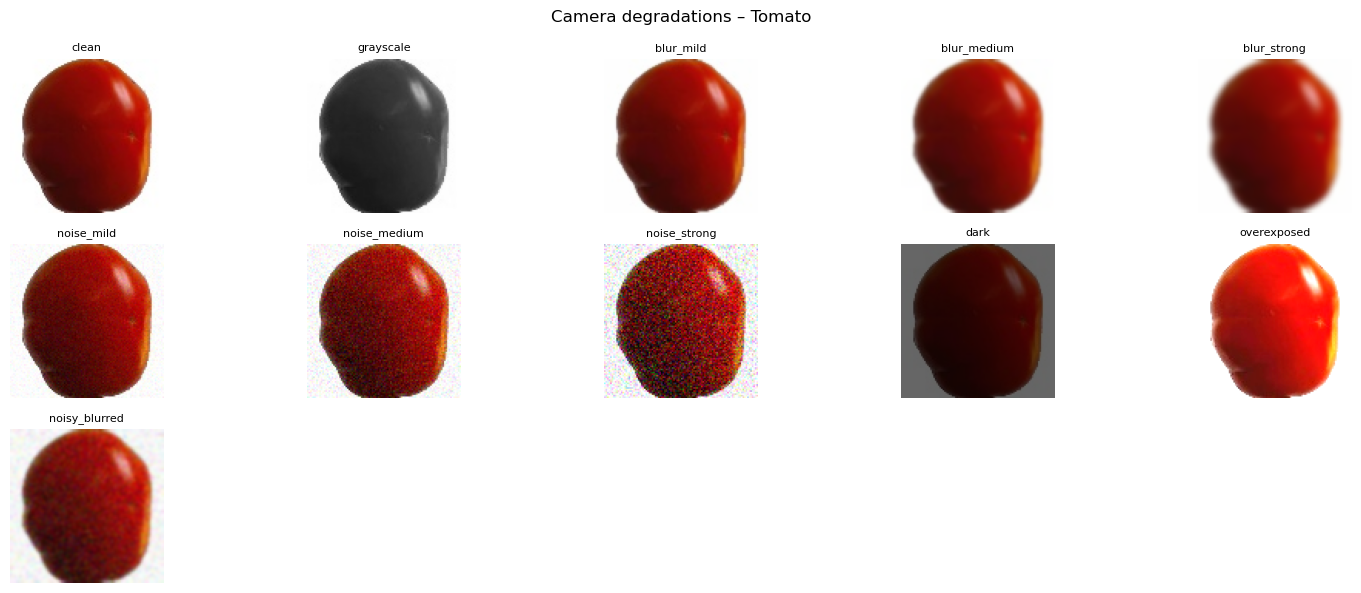

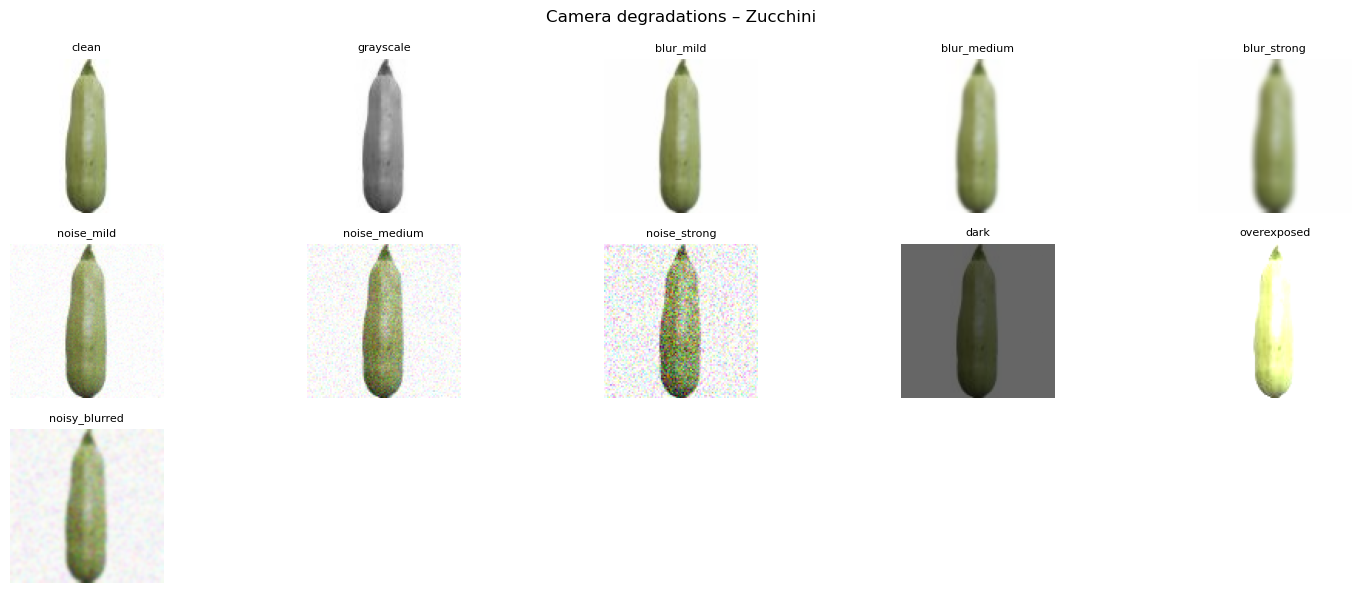

In [13]:
num_examples_camera = min(8, len(examples))

for i in range(num_examples_camera):
    img, label = examples[i]
    show_degradations_for_image(
        img_tensor=img,
        label=label,
        degradations_dict=degradations_camera,
        title_prefix="Camera degradations",
        n_cols=5,
        figsize=(15, 6)
    )


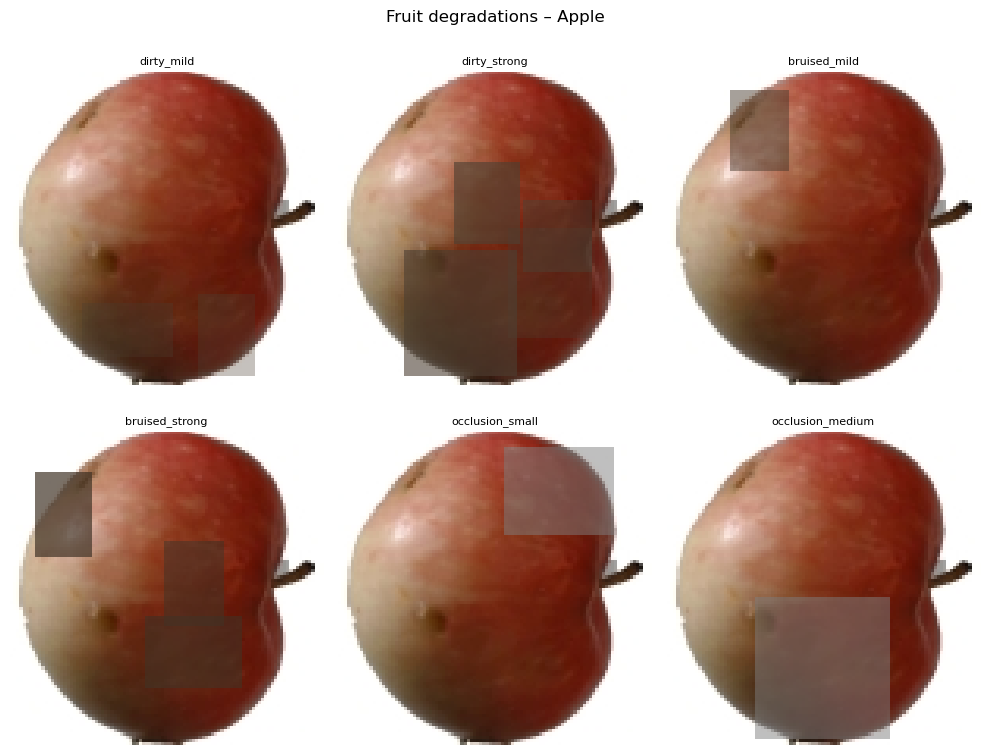

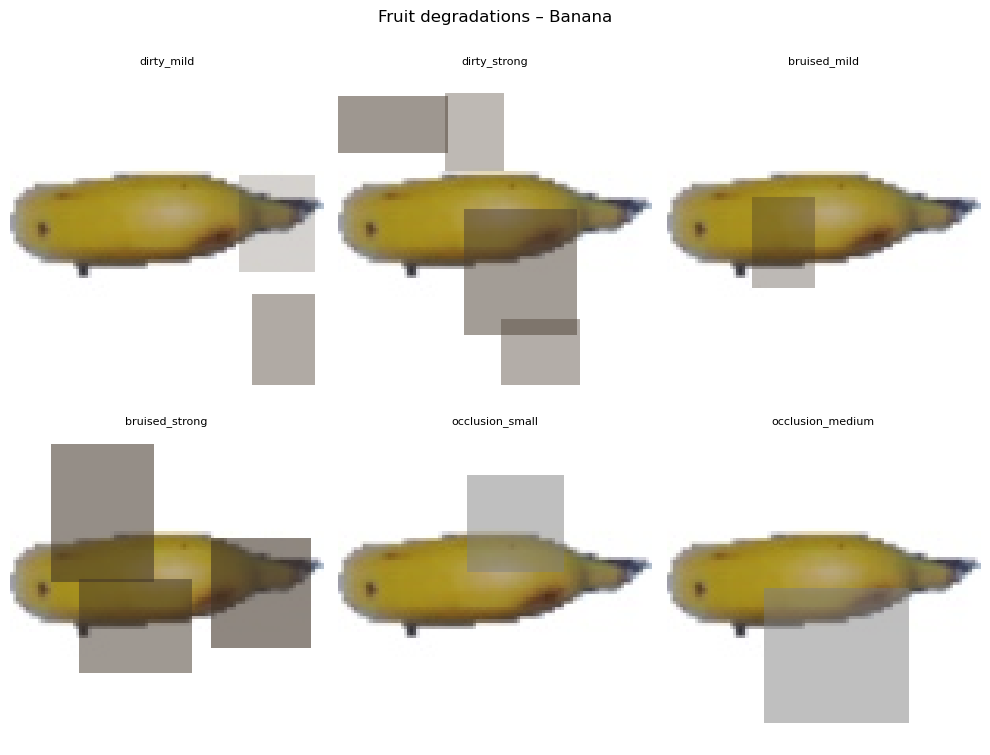

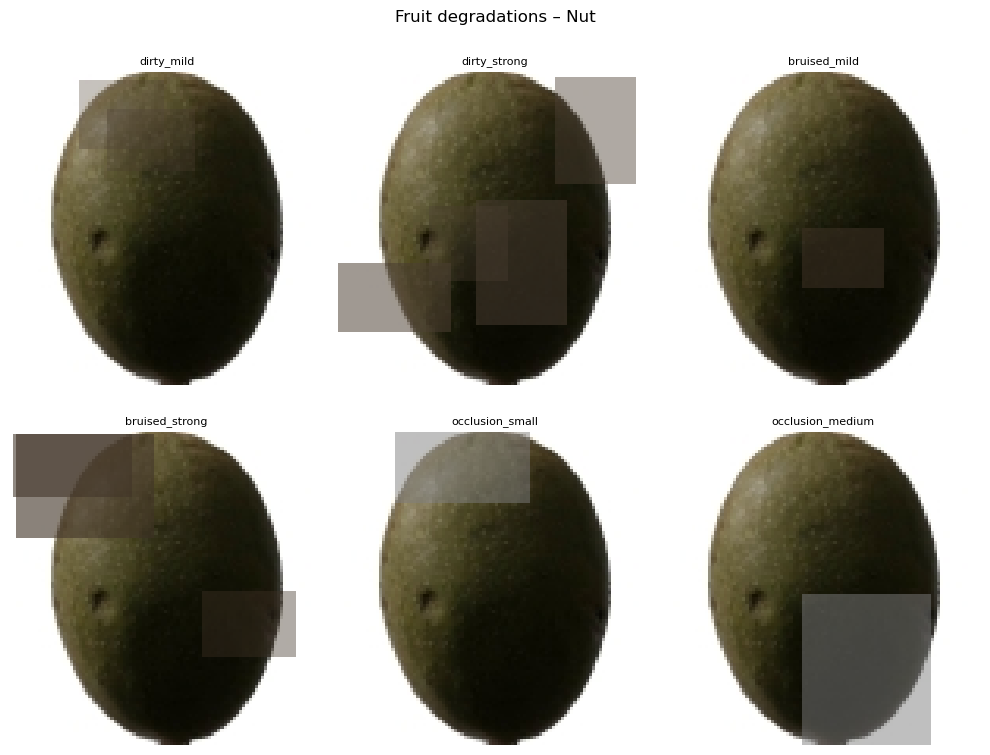

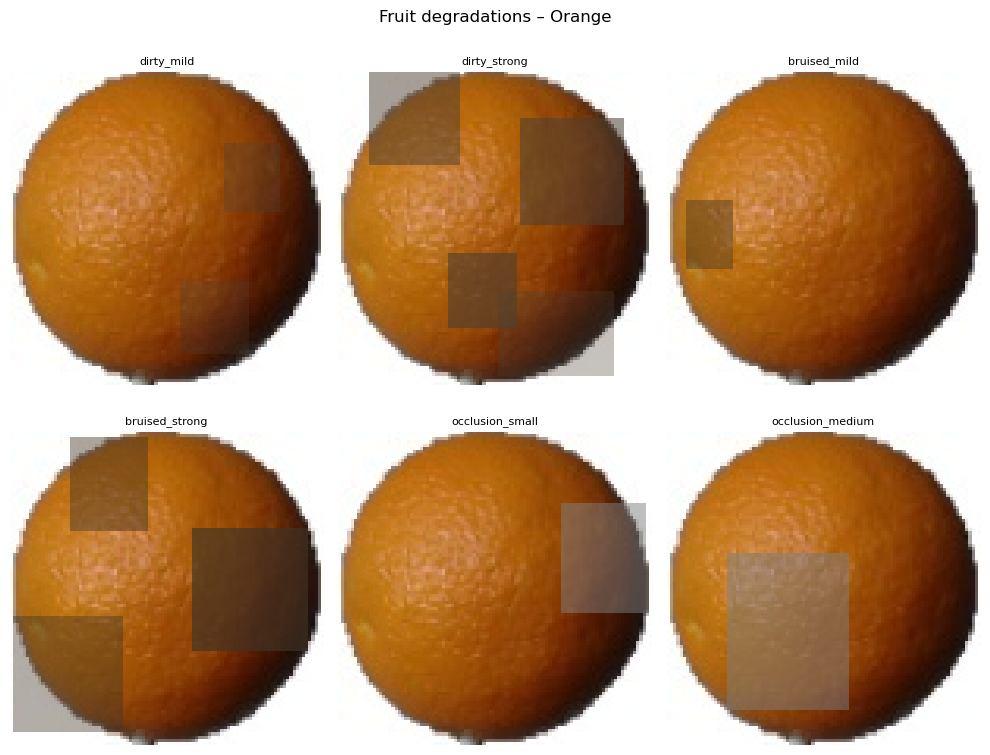

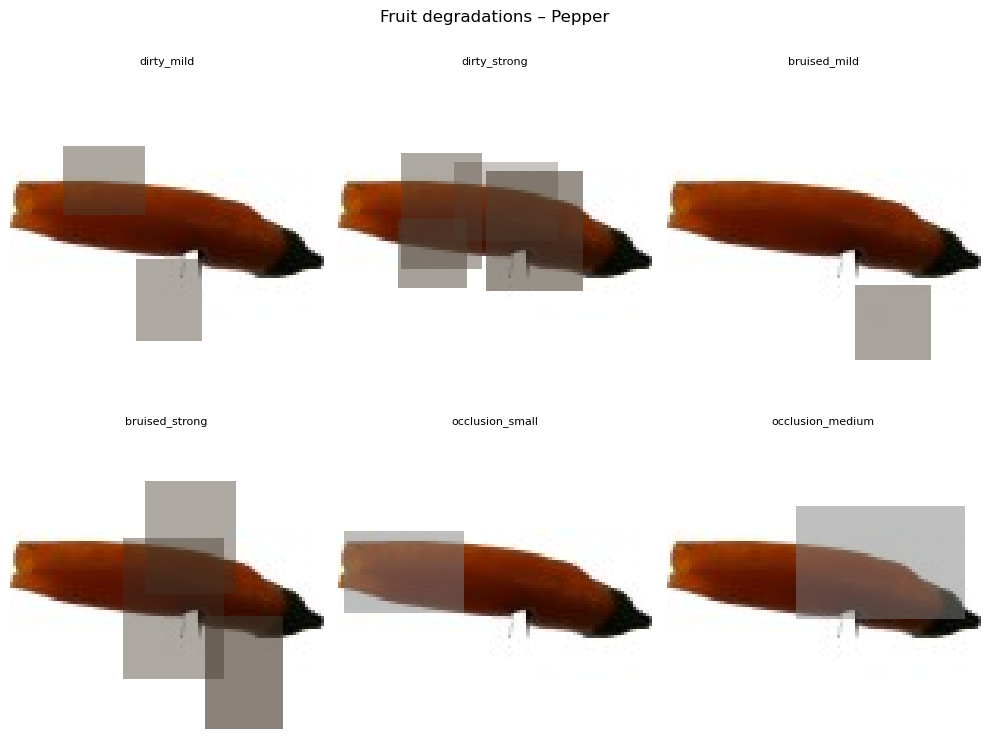

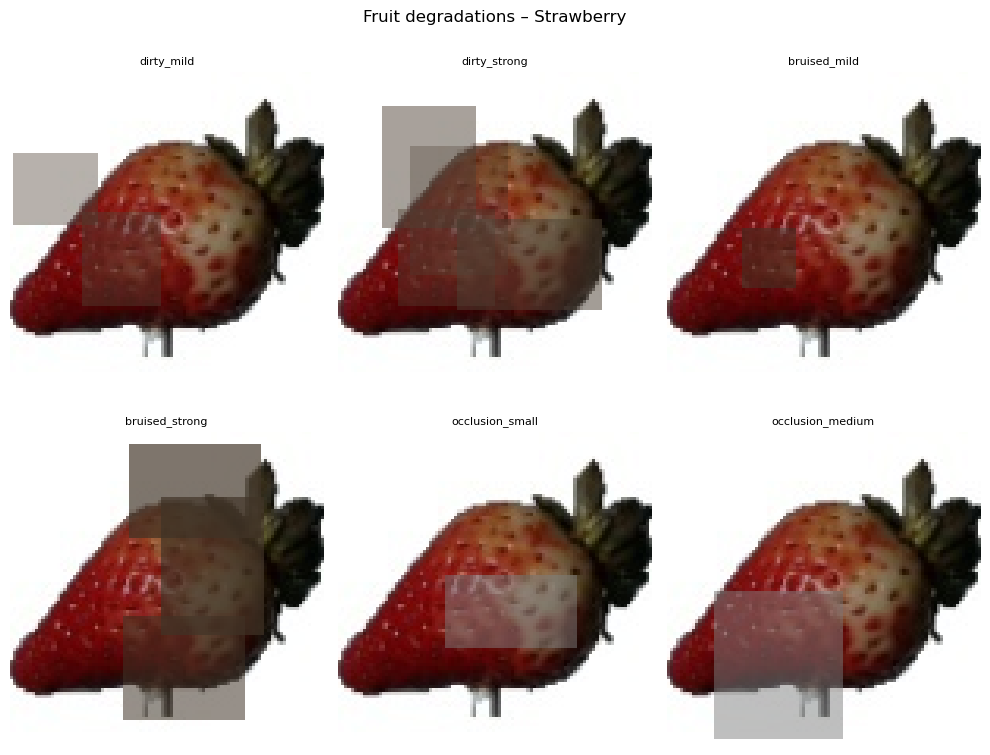

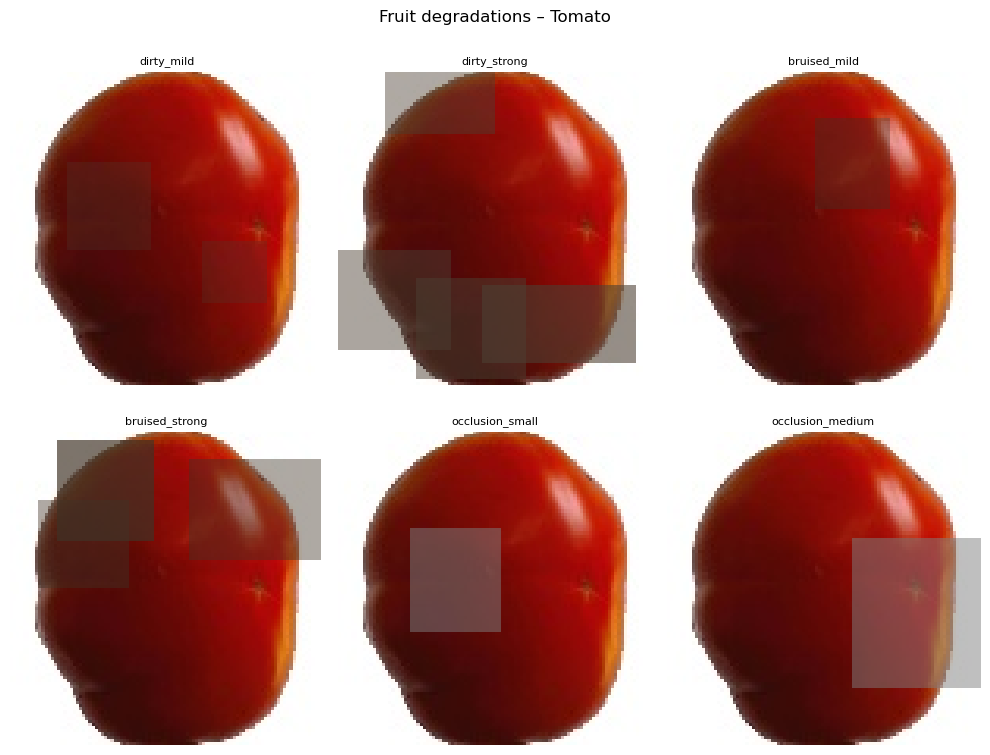

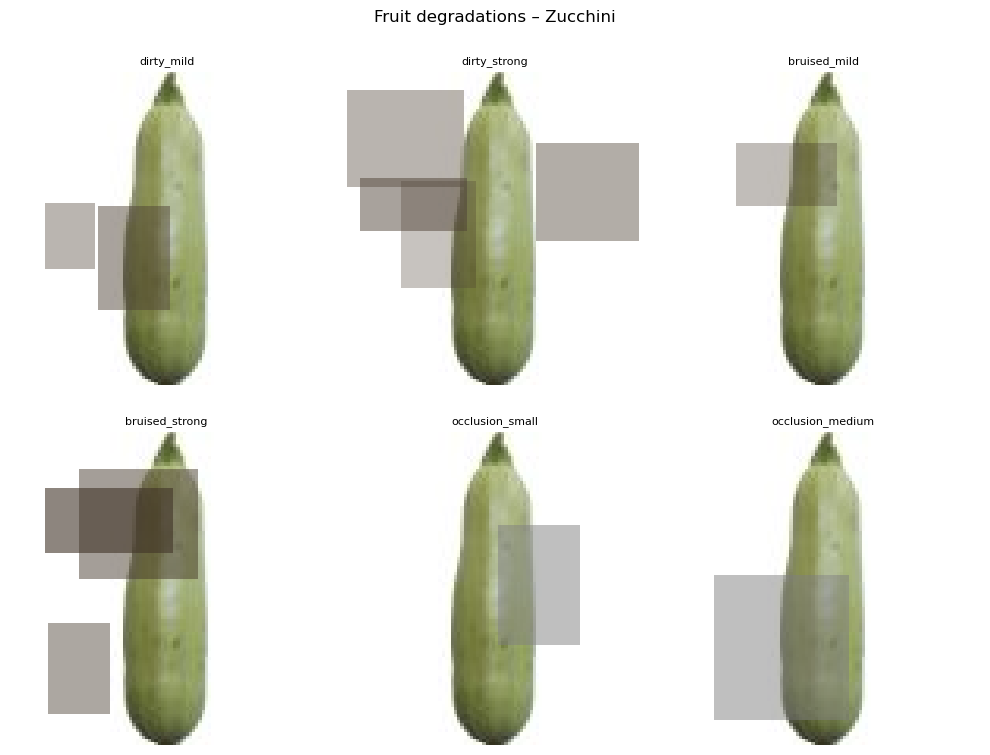

In [14]:
start_idx = 0
num_examples_fruit = min(8, len(examples) - start_idx)

for i in range(start_idx, start_idx + num_examples_fruit):
    img, label = examples[i]
    show_degradations_for_image(
        img_tensor=img,
        label=label,
        degradations_dict=degradations_fruit,
        title_prefix="Fruit degradations",
        n_cols=3,
        figsize=(10, 8)
    )


In [ ]:
import io

def jpeg_compression(tensor, quality):
    """
    Applica compressione JPEG con quality factor (1-100).
    quality=100 → nessuna perdita visibile
    quality=70 → mild compression (standard web)
    quality=40 → medium compression (artefatti visibili)
    quality=20 → strong compression (blocchetti 8x8 evidenti)
    """
    # tensor 3×H×W [0,1] → PIL
    img = TF.to_pil_image(tensor)
    
    buffer = io.BytesIO()
    img.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    
    img_compressed = Image.open(buffer)
    
    return TF.to_tensor(img_compressed)

degradations_jpeg = {
    "jpeg_mild": lambda x: jpeg_compression(x, quality=70),
    "jpeg_medium": lambda x: jpeg_compression(x, quality=40),
    "jpeg_strong": lambda x: jpeg_compression(x, quality=20),
}

print("JPEG compression degradations:")
for k in degradations_jpeg.keys():
    print(" -", k)


JPEG compression degradations:
 - jpeg_mild
 - jpeg_medium
 - jpeg_strong


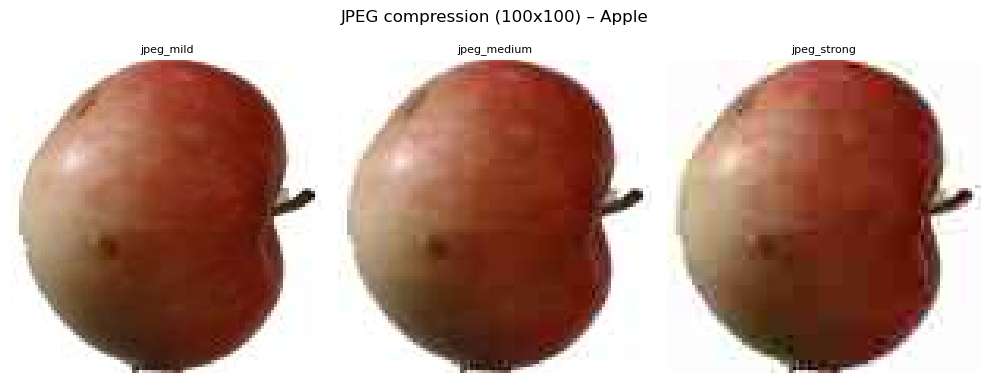

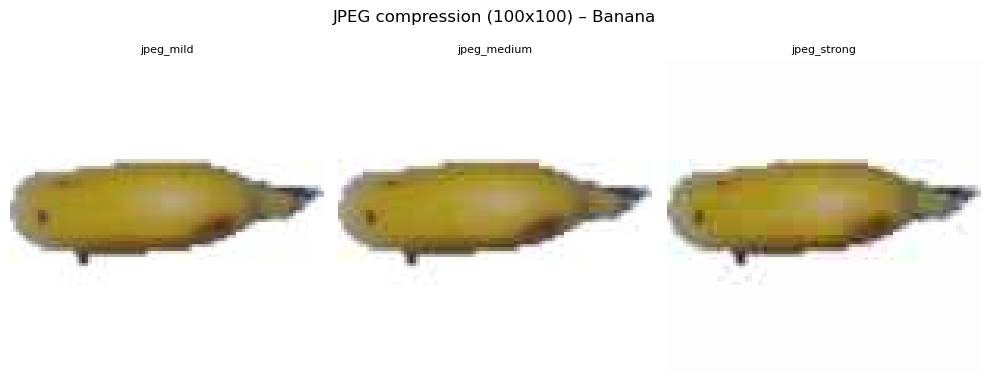

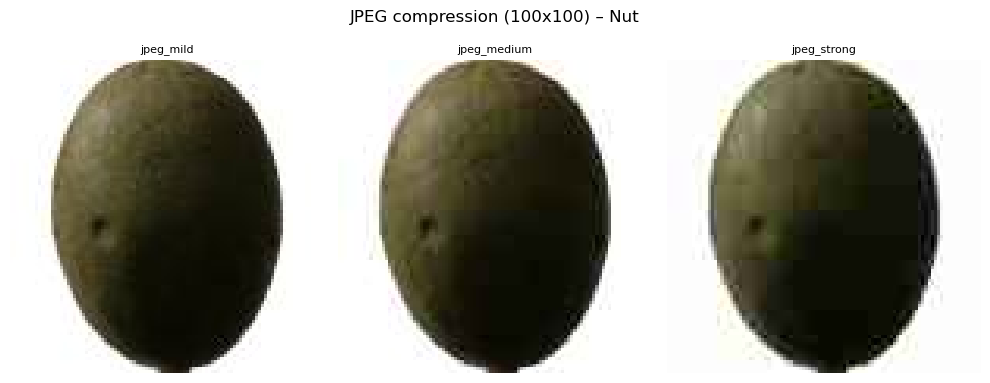

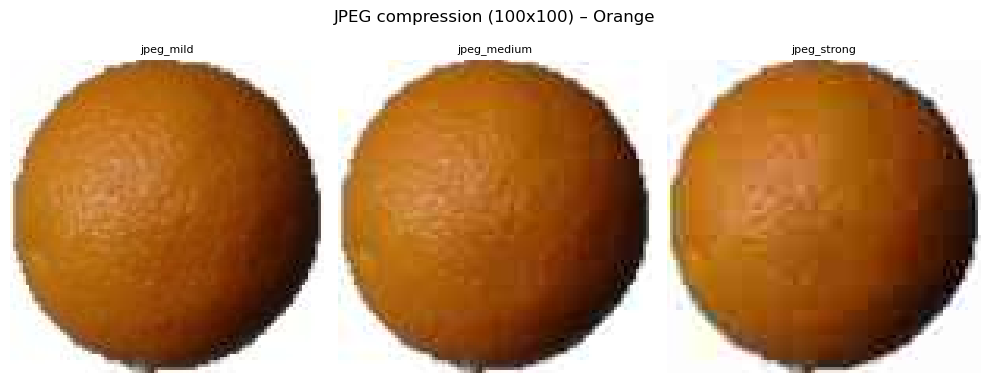

In [16]:
num_examples_jpeg = min(4, len(examples))

for i in range(num_examples_jpeg):
    img, label = examples[i]
    show_degradations_for_image(
        img_tensor=img,
        label=label,
        degradations_dict=degradations_jpeg,
        title_prefix="JPEG compression (100x100)",
        n_cols=3,
        figsize=(10, 4)
    )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.026296066..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019796463..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0145531185..1.0000001].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008823051..1.0000001].


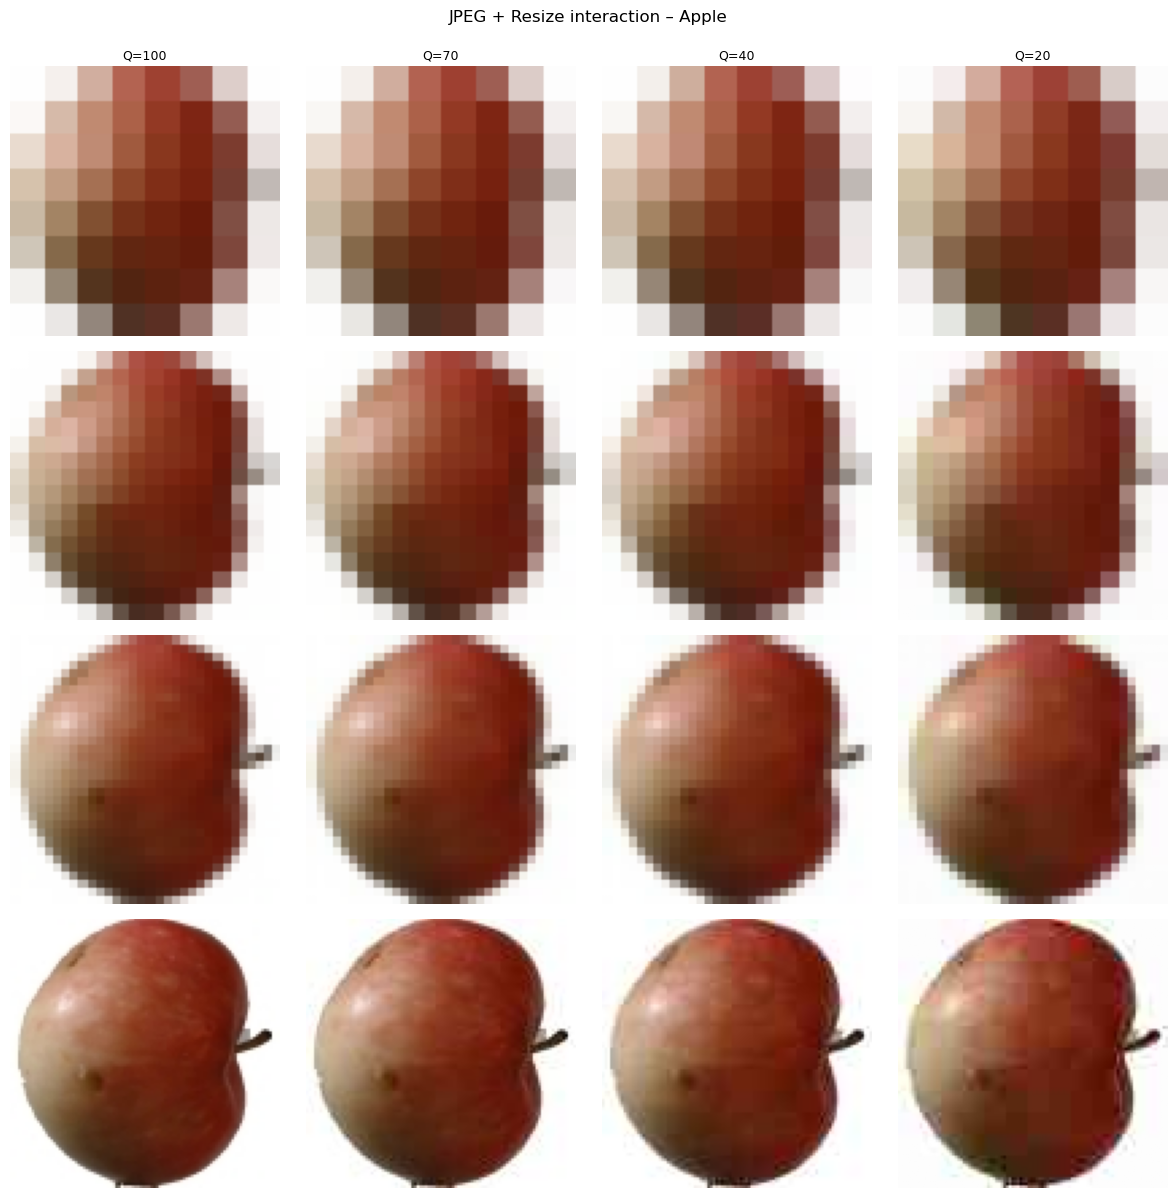

In [ ]:

test_img, test_label = examples[0]

sizes_to_test = [8, 16, 32, 100]  # 100 = original

jpeg_qualities = [100, 70, 40, 20]  # 100 = clean

fig, axes = plt.subplots(len(sizes_to_test), len(jpeg_qualities), figsize=(12, 12))

for i, size in enumerate(sizes_to_test):
    for j, quality in enumerate(jpeg_qualities):
        img_jpeg = jpeg_compression(test_img, quality=quality)
        
        if size != 100:
            img_resized = TF.resize(img_jpeg, (size, size))
        else:
            img_resized = img_jpeg
        
        img_display = TF.resize(img_resized, (100, 100), interpolation=T.InterpolationMode.NEAREST)
        
        # Plot
        ax = axes[i, j]
        img_np = img_display.permute(1, 2, 0).cpu().numpy()
        ax.imshow(img_np)
        
        if i == 0:
            ax.set_title(f"Q={quality}", fontsize=9)
        if j == 0:
            ax.set_ylabel(f"{size}×{size}", fontsize=9, rotation=0, ha='right', va='center')
        
        ax.axis('off')

plt.suptitle(f"JPEG + Resize interaction – {test_label}", fontsize=12, y=0.995)
plt.tight_layout()
plt.show()


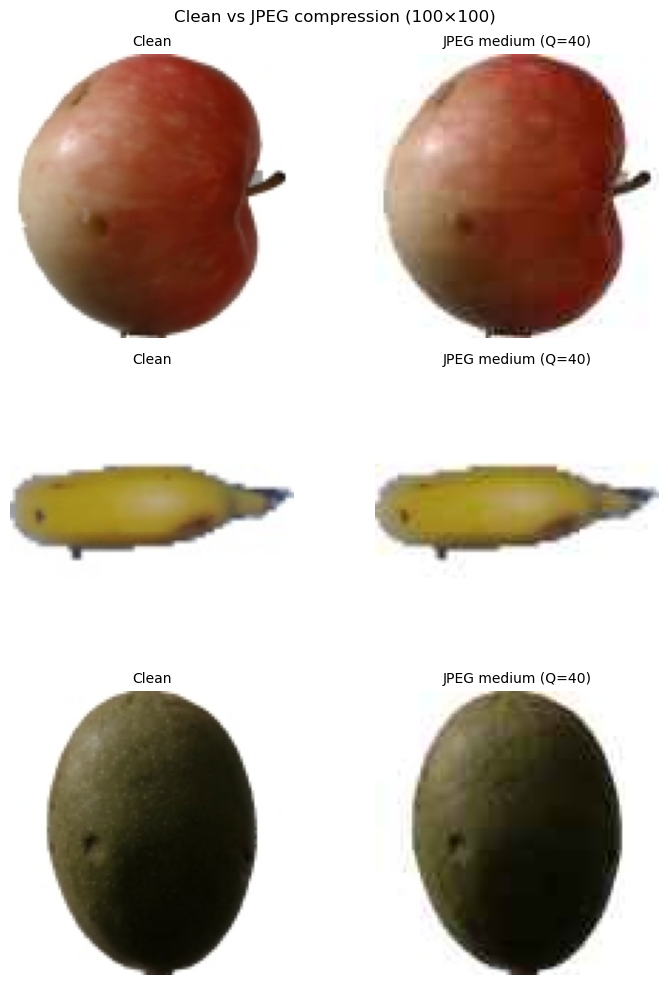

In [ ]:
fruits_to_compare = examples[:3]  # Apple, Banana, Nut

fig, axes = plt.subplots(len(fruits_to_compare), 2, figsize=(8, 10))

for i, (img, label) in enumerate(fruits_to_compare):
    # Clean
    ax_clean = axes[i, 0]
    img_clean_np = img.permute(1, 2, 0).cpu().numpy()
    ax_clean.imshow(img_clean_np)
    ax_clean.set_title("Clean", fontsize=10)
    ax_clean.axis('off')
    
    # JPEG medium
    ax_jpeg = axes[i, 1]
    img_jpeg = jpeg_compression(img, quality=40)
    img_jpeg_np = img_jpeg.permute(1, 2, 0).cpu().numpy()
    ax_jpeg.imshow(img_jpeg_np)
    ax_jpeg.set_title("JPEG medium (Q=40)", fontsize=10)
    ax_jpeg.axis('off')
    
    axes[i, 0].set_ylabel(label, fontsize=11, rotation=0, ha='right', va='center')

plt.suptitle("Clean vs JPEG compression (100×100)", fontsize=12)
plt.tight_layout()
plt.show()


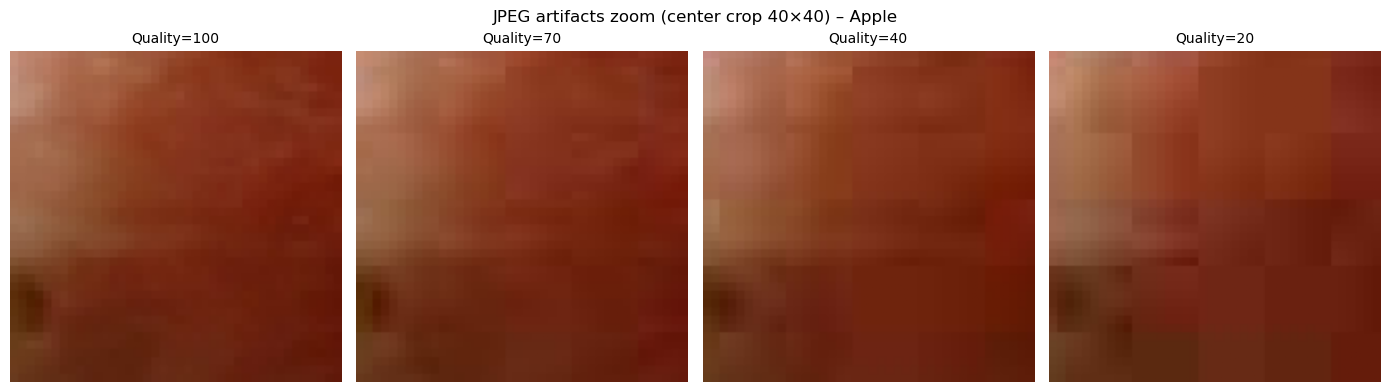

In [ ]:
test_img, test_label = examples[0]  # Apple

def crop_center(tensor, crop_size=40):
    _, H, W = tensor.shape
    top = (H - crop_size) // 2
    left = (W - crop_size) // 2
    return tensor[:, top:top+crop_size, left:left+crop_size]

qualities = [100, 70, 40, 20]

fig, axes = plt.subplots(1, len(qualities), figsize=(14, 4))

for j, quality in enumerate(qualities):
    # JPEG compression
    img_jpeg = jpeg_compression(test_img, quality=quality)
    
    # Crop
    img_crop = crop_center(img_jpeg, crop_size=40)
    
    # Upscale
    img_zoom = TF.resize(img_crop, (120, 120), interpolation=T.InterpolationMode.NEAREST)
    
    ax = axes[j]
    img_np = img_zoom.permute(1, 2, 0).cpu().numpy()
    ax.imshow(img_np)
    ax.set_title(f"Quality={quality}", fontsize=10)
    ax.axis('off')

plt.suptitle(f"JPEG artifacts zoom (center crop 40×40) – {test_label}", fontsize=12)
plt.tight_layout()
plt.show()
